# 3. Test model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from gensim.models import Word2Vec
import gensim.downloader as gensim_downloader
from api import GenderBiasScorer, EnsembleGenderBiasScorer, percentage_bias, biased_words

## 3.1 Test different vocab models on lexicons and tune thresholds

First load models: models trained on 5 datasets, and one pretrained from Google (see [here](https://github.com/RaRe-Technologies/gensim-data))

In [3]:
model_names = ["wikibios_merged", "bug", "bug_stereotype", "doughman", "doughman_stereotype"]
scorers = [GenderBiasScorer(Word2Vec.load(f"models/dataset_{i}.pt").wv) for i in tqdm(model_names)]

100%|███████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]

Bias group words masculine, feminine not found in model vocabulary
Bias group words male, female not found in model vocabulary
Bias group words masculine, feminine not found in model vocabulary
Bias group words men, women not found in model vocabulary
Bias group words male, female not found in model vocabulary
Bias group words masculine, feminine not found in model vocabulary
Bias group words men, women not found in model vocabulary


In [4]:
wv_pretrained = gensim_downloader.load('word2vec-google-news-300')
#wv_pretrained = gensim_downloader.load('glove-wiki-gigaword-100')

In [5]:
model_names.append("word2vec-google-news-300")
scorers.append(GenderBiasScorer(wv_pretrained))

Testing on lexicons to find best embedding models (requires making full lexicons). I.e. get accuracy using test lexicon on all embedding models + pretrained + tune threshs for each one

In [6]:
threshs = np.arange(0, 0.5, 0.02)

In [9]:
def tune_and_evaluate_models(scorers, model_names, threshs=threshs):
    # Tune scoring thresholds for models and return evaluation metrics
    threshs_optimal = np.zeros(len(scorers))
    test_accuracies = np.zeros(len(scorers))
    bias_accuracies = np.zeros(len(scorers))
    n_absent_words  = np.zeros(len(scorers))
    human_correlations = np.zeros(len(scorers))
    for i,scorer in enumerate(scorers):
        
        accuracies = np.zeros(len(threshs))
        for j,thresh in enumerate(threshs):
            accuracies[j] = scorer.lexicon_accuracy("test", thresh=thresh)

        threshs_optimal[i] = threshs[accuracies.argmax()]
        test_accuracies[i] = accuracies[accuracies.argmax()]
        bias_accuracies[i] = scorer.lexicon_accuracy("bias", thresh=threshs_optimal[i])
        human_correlations[i] = scorer.eval_gensim_human_dataset()
        n_absent_words[i] = scorer.lexicon_n_absent_words("bias")

    results = pd.DataFrame({"model_names": model_names, "n_absent_words": n_absent_words, 
                            "threshs_optimal": threshs_optimal, "test_accuracies": test_accuracies, 
                            "bias_accuracies": bias_accuracies, "human_correlations": human_correlations})
    return results

In [10]:
results = tune_and_evaluate_models(scorers, model_names, threshs)

Tokens co-operative not found in model vocabulary
Tokens yielding not found in model vocabulary
Tokens punctual not found in model vocabulary
Tokens tenaciousness not found in model vocabulary
Tokens reassurance not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
T

<AxesSubplot:xlabel='model_names', ylabel='bias_accuracies'>

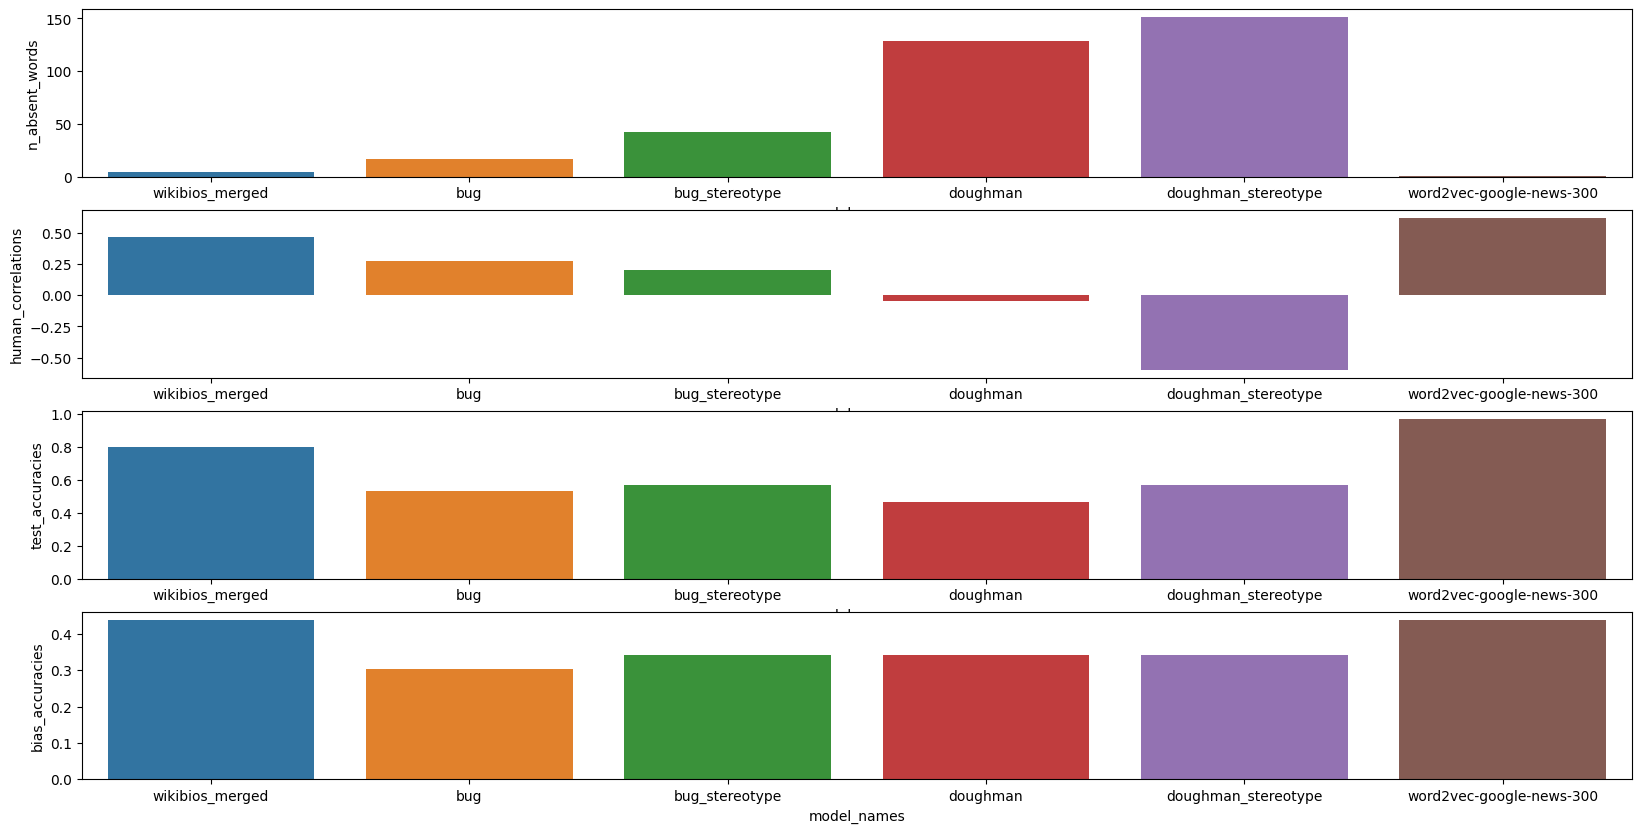

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(4,1,1)
sns.barplot(results, x="model_names", y="n_absent_words")
plt.subplot(4,1,2)
sns.barplot(results, x="model_names", y="human_correlations")
plt.subplot(4,1,3)
sns.barplot(results, x="model_names", y="test_accuracies")
plt.subplot(4,1,4)
sns.barplot(results, x="model_names", y="bias_accuracies")

## 3.3 Create ensemble model out of best `model.wv`s 

We choose models `wikibios_merged`, `bug`, and `word2vec-google-news-300` for creating ensemble model. The model's gender bias scoring will take a majority-voting approach.

In [13]:
ensemble_scorer = EnsembleGenderBiasScorer(wvs=[Word2Vec.load(f"models/dataset_{i}.pt").wv for i in ["wikibios_merged", "bug"]] + [wv_pretrained],
                                       threshs=results[results["model_names"].isin(("wikibios_merged", "bug", "word2vec-google-news-300"))]["threshs_optimal"].to_numpy())

Compare original models with ensemble model

In [15]:
model_names = ["wikibios_merged", "bug", "word2vec-google-news-300", "ensemble"]
wvs = [Word2Vec.load(f"models/dataset_{i}.pt").wv for i in ["wikibios_merged", "bug"]] + [wv_pretrained]
scorers = [GenderBiasScorer(wv) for wv in wvs] + [ensemble_scorer]
results = tune_and_evaluate_models(scorers, model_names, threshs)

Tokens co-operative not found in model vocabulary
Tokens yielding not found in model vocabulary
Tokens punctual not found in model vocabulary
Tokens tenaciousness not found in model vocabulary
Tokens reassurance not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
Tokens gal not found in model vocabulary
Tokens fatherly not found in model vocabulary
Tokens motherly not found in model vocabulary
T

100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 12.31it/s]


<AxesSubplot:xlabel='model_names', ylabel='human_correlations'>

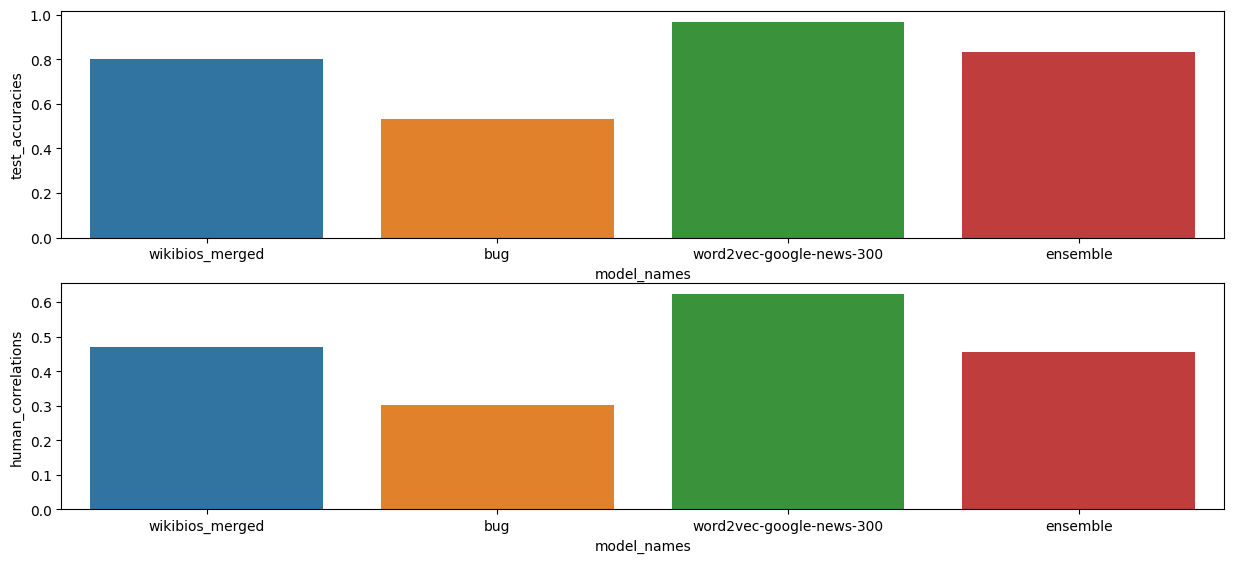

In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
sns.barplot(results, x="model_names", y="test_accuracies")
plt.subplot(3,1,2)
sns.barplot(results, x="model_names", y="bias_accuracies")
plt.subplot(3,1,2)
sns.barplot(results, x="model_names", y="human_correlations")

In [19]:
ensemble_scorer.lexicon_accuracy("bias", verbose=True)

Tokens headstrong not found in model vocabulary
Tokens individualistic not found in model vocabulary
Tokens cheery not found in model vocabulary
Tokens co-operative not found in model vocabulary
Tokens co-operative not found in model vocabulary
Tokens co-operative not found in model vocabulary
Tokens interdependent not found in model vocabulary
Tokens nagging not found in model vocabulary
Tokens whine not found in model vocabulary
Tokens inclusive not found in model vocabulary
Tokens yielding not found in model vocabulary
Tokens yielding not found in model vocabulary
Tokens adaptable not found in model vocabulary
Tokens engaged not found in model vocabulary
Tokens likable not found in model vocabulary
Tokens likeable not found in model vocabulary
Tokens punctual not found in model vocabulary
Tokens punctual not found in model vocabulary
Tokens rewarding not found in model vocabulary
Tokens tenacious not found in model vocabulary
Tokens tenaciousness not found in model vocabulary
Tokens

0.41935483870967744

In [126]:
test_document = "My guess is she can afford to pay a nutritionist who limits her to a reasonable caloric intake and a personal trainer who keeps her on a workout plan."

In [127]:
tokens, scores = ensemble_scorer.score_document(test_document)

[0, 0, 0] 0
[-1, 0, -1] -1
[0, 0, 0] 0
[0, 0, 0] 0
[-1, 0, -1] -1
[0, 0, 0] 0
[0, 0, -1] 0
[0, 0, 0] 0
Tokens caloric not found in model vocabulary
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, 0] 0
[0, 0, -1] 0
[0, 0, 0] 0
[0, 0, 0] 0


In [128]:
percentage_bias(test_document, scores)

0.08

In [129]:
biased_words(tokens, scores)

{'biased_m': [],
 'biased_f': ['she', 'nutritionist'],
 'unbiased': ['guess',
  'afford',
  'pay',
  'limit',
  'her',
  'reasonable',
  'caloric',
  'intake',
  'personal',
  'trainer',
  'her',
  'workout',
  'plan']}

Wordcloud vis

In [20]:
with open("data/corpus/dataset_doughman.txt", "r") as f:
    document = " ".join(f.read().splitlines())

In [87]:
ensemble_scorer.threshs = [0.26, 0.16, 0.08]

In [21]:
#prefer these
ensemble_scorer.threshs = [0.4, 0.8, 0.13]

In [22]:
scorer = ensemble_scorer
#scorer = GenderBiasScorer(wvs[2])
tokens, scores = scorer.score_document(document, thresh=0.13)

Tokens rhymist not found in model vocabulary
Tokens rhymist not found in model vocabulary
Tokens rhymist not found in model vocabulary
Tokens indigestion not found in model vocabulary
Tokens indigestion not found in model vocabulary
Tokens eczema not found in model vocabulary
Tokens eczema not found in model vocabulary
Tokens rheumatism not found in model vocabulary
Tokens sterilize not found in model vocabulary
Tokens sterilize not found in model vocabulary
Tokens counselling not found in model vocabulary
Tokens ther not found in model vocabulary
Tokens vinyls not found in model vocabulary
Tokens vinyls not found in model vocabulary
Tokens periodontal not found in model vocabulary
Tokens hatha not found in model vocabulary
Tokens hatha not found in model vocabulary
Tokens charges not found in model vocabulary
Tokens charges not found in model vocabulary
Tokens endodontist not found in model vocabulary
Tokens endodontist not found in model vocabulary
Tokens consumables not found in mod

In [23]:
percentage_bias(document, scores)

0.010056640850768697

In [24]:
words = biased_words(tokens, scores)
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

m {'ball', 'men', 'guy', 'team', 'game', 'dude', 'himself', 'captain', 'club', 'heckle', 'man'}
f {'paralegal', 'teresa', 'cardi', 'wendy', 'psychotherapist', 'sister', 'kaur', 'niece', 'caregiver', 'homemaker', 'she', 'lisa', 'female', 'woman', 'sophie', 'sylvia', 'hygienist', 'national', 'nutritionist', 'boyfriend'}


In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

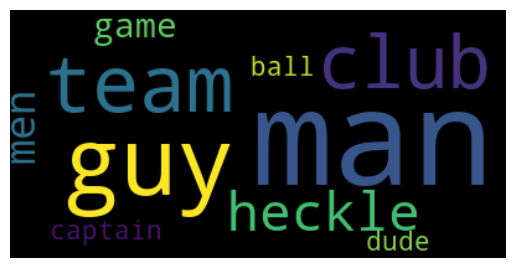

In [26]:
wordcloud = WordCloud().generate(" ".join(words["biased_m"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

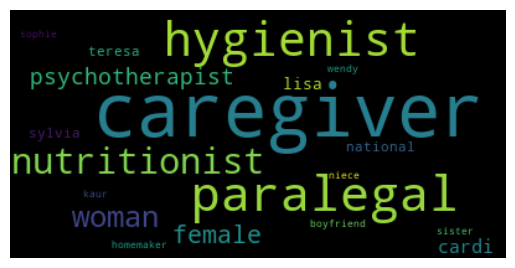

In [27]:
wordcloud = WordCloud().generate(" ".join(words["biased_f"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
with open("data/eval/kainosspecs.txt", "r") as f:
    document = " ".join(f.read().splitlines())

In [30]:
scorer = ensemble_scorer
tokens, scores = scorer.score_document(document)
words = biased_words(tokens, scores)
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

Tokens kainos not found in model vocabulary
Tokens kainos not found in model vocabulary
Tokens kainos not found in model vocabulary
Tokens stakeholder not found in model vocabulary
Tokens requirements not found in model vocabulary
Tokens requirements not found in model vocabulary
Tokens programme not found in model vocabulary
Tokens prioritise not found in model vocabulary
Tokens prioritise not found in model vocabulary
Tokens nlp not found in model vocabulary
Tokens nlp not found in model vocabulary
Tokens understands not found in model vocabulary
Tokens stakeholder not found in model vocabulary
Tokens prioritise not found in model vocabulary
Tokens prioritise not found in model vocabulary
Tokens aws not found in model vocabulary
Tokens azure not found in model vocabulary
Tokens saas not found in model vocabulary
Tokens paas not found in model vocabulary
Tokens stakeholder not found in model vocabulary
Tokens understands not found in model vocabulary
Tokens demonstrated not found in m